# Модель предсказания успешности стартапа
Цель исследования - построить модель, которая сможет предсказать закрытие стартапа по данным в период с 1970 по 2018 годы.
Описание данных:
- name - Название стартапа;
- category_list - Список категорий, к которым относится стартап;
- funding_total_usd - Общая сумма финансирования в USD;
- status - Статус стартапа (закрыт или действующий);
- country_code - Код страны;
- state_code - Код штата;
- region - Регион;
- city - Город;
- funding_rounds - Количество раундов финансирования;
- founded_at - Дата основания;
- first_funding_at - Дата первого раунда финансирования;
- last_funding_at - Дата последнего раунда финансирования;
- closed_at - Дата закрытия стартапа (если применимо);
- lifetime - Время существования стартапа в днях.

# 1. Загрузка и предобработка данных

In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from phik import phik_matrix
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [463]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [464]:
# тренировочная выборка
train_data = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_train_28062024.csv')
train_data.Name = 'train_data'
# входные признаки тестовой выборки
test_features = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-37-ds/kaggle_startups_test_28062024.csv')
test_features.Name = 'test_features'

Выведем общую информацию о датафреймах и их первые записи:

In [465]:
display(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [466]:
display(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


Приведем тип данных столбцов first_funding_at, last_funding_at и founded_at к datetime:

In [467]:
train_data[['founded_at', 'first_funding_at', 'last_funding_at']] = \
train_data[['founded_at', 'first_funding_at', 'last_funding_at']].apply(pd.to_datetime, format = "%Y-%m-%d")
test_features[['first_funding_at', 'last_funding_at']] = \
test_features[['first_funding_at', 'last_funding_at']].apply(pd.to_datetime, format = "%Y-%m-%d")

In [468]:
train_data.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


В данных присутствуют пропуски. Заполним их:
 - пропуски в столбцах category_list, country_code, state_code, region, city заменим на 'other';
 - пропуски в funding_total_usd заменим медианным значением суммы финансирования для стартапов с аналогичным количеством раундов финансирования.

In [469]:
col_to_replace = ["category_list","country_code","state_code","region","city"]
for df in [train_data, test_features]:
    df[col_to_replace] = df[col_to_replace].replace({np.nan: 'other'})

In [470]:
train_data['funding_total_usd'] = train_data['funding_total_usd'].fillna(train_data.groupby('funding_rounds')['funding_total_usd'].transform('mean'))
test_features['funding_total_usd'] = test_features['funding_total_usd'].fillna(train_data.groupby('funding_rounds')['funding_total_usd'].transform('mean'))

Проверим данные:

In [471]:
display(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(8)
memory 

None

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,2.225000e+07,operating,other,other,other,other,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,9.302247e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [472]:
display(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2.819200e+06,NIC,17,other,other,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,3.439820e+07,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,4.282570e+05,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,3.470000e+07,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4.530000e+06,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


Проверми наличие неявных дубликатов в столбце country_code:

Неявных дубликатов необнаружено. Проверим наличие янвых дубликатов в датафрейме:

In [473]:
train_data.duplicated().sum()

0

Явные дубликаты отсутствуют.

Таким образом, столбцы в датафреймах имеют корректные типы данных, отсутствуют пропуски и явные дубликаты. С такими данными можно продолжать работу.

## Выводы по первому этапу
- Импортированы необходимые для работы библиотеки.
- Прочитаны и загружены в датафреймы файлы с исходными данными.
- Получена общая информация о данных (столбцы, типы данных).
- Произведено преобразование типов данных столбцов.
- Обнаружены и заполнены пропуски в данных.

# 2. Исследовательский анализ данных

Проведем исследовательский анализ исходных данных. Для этого создадим вспомогательные функции:

Создадим функцию plot_cat_features для построения графиков для категориальных признаков:

In [474]:
def plot_cat_features(df):
    for column in df.columns:
        print(f'Нормализованное распределение признака {column}:')
        print(df[column].value_counts(normalize = True))
        ax = df[column].value_counts().plot(kind = 'bar', figsize = (21, 9))
        ax.set_xlabel(column)
        ax.set_ylabel('Частота встречаемости')
        ax.set_title(f'График распределения признака {column}')
        plt.show()
        print('\n\n')

А также функцию plot_num_features для построения графиков для количественных признаков:

In [475]:
def plot_num_features(df):
    for column in df.columns:
        plt.figure(figsize = (21, 9))
        # Гистограмма
        data = df[column]
        plt.subplot(2,1,1)
        plt.hist(data, histtype='bar') 
        plt.xlabel(column)
        plt.ylabel('Частота встречаемости')
        plt.title(f'Распределение признака {column}')
        # Диаграмма размаха
        plt.subplot(2,1,2)
        plt.boxplot(data, vert = False)
        plt.ylabel(f'Диаграмма размаха {column}')
        plt.xlabel(column)
        plt.show()
        print(f'Среднее значение признака {column}: {data.mean():.2f}')
        print(f'Медианное значение признака {column}: {data.median():.2f}')
        print('\n\n\n')

А также функцию plot_datetime_features для построения графиков для признаков времени:

In [476]:
def plot_datetime_features(df):
    for column in df.columns:
        print(f'Распределение признака {column}:')
        ax = df[column].hist(histtype = 'bar', figsize = (21, 9))
        ax.set_xlabel(column)
        ax.set_ylabel('Частота встречаемости')
        ax.set_title(f'График распределения признака {column}')
        plt.show()
        print(f'Медианное значение признака {column}: {df[column].quantile(0.5, interpolation="midpoint")}')
        print('\n\n\n')

Создадим списки с категориальными и количественными признаками датафрейма train_data:

In [477]:
# Признаки state_code, region, city рассматривать не станем, ограничимся признаком country_code
# Признак name неинформативен, а структура признака category_list не позволяет провести доступный анализ - их рассматривать также не станем
cat_features = ['status', 'country_code']
num_features = ['funding_total_usd', 'funding_rounds']
datetime_features = ['founded_at', 'first_funding_at', 'last_funding_at']

Нормализованное распределение признака status:
status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64


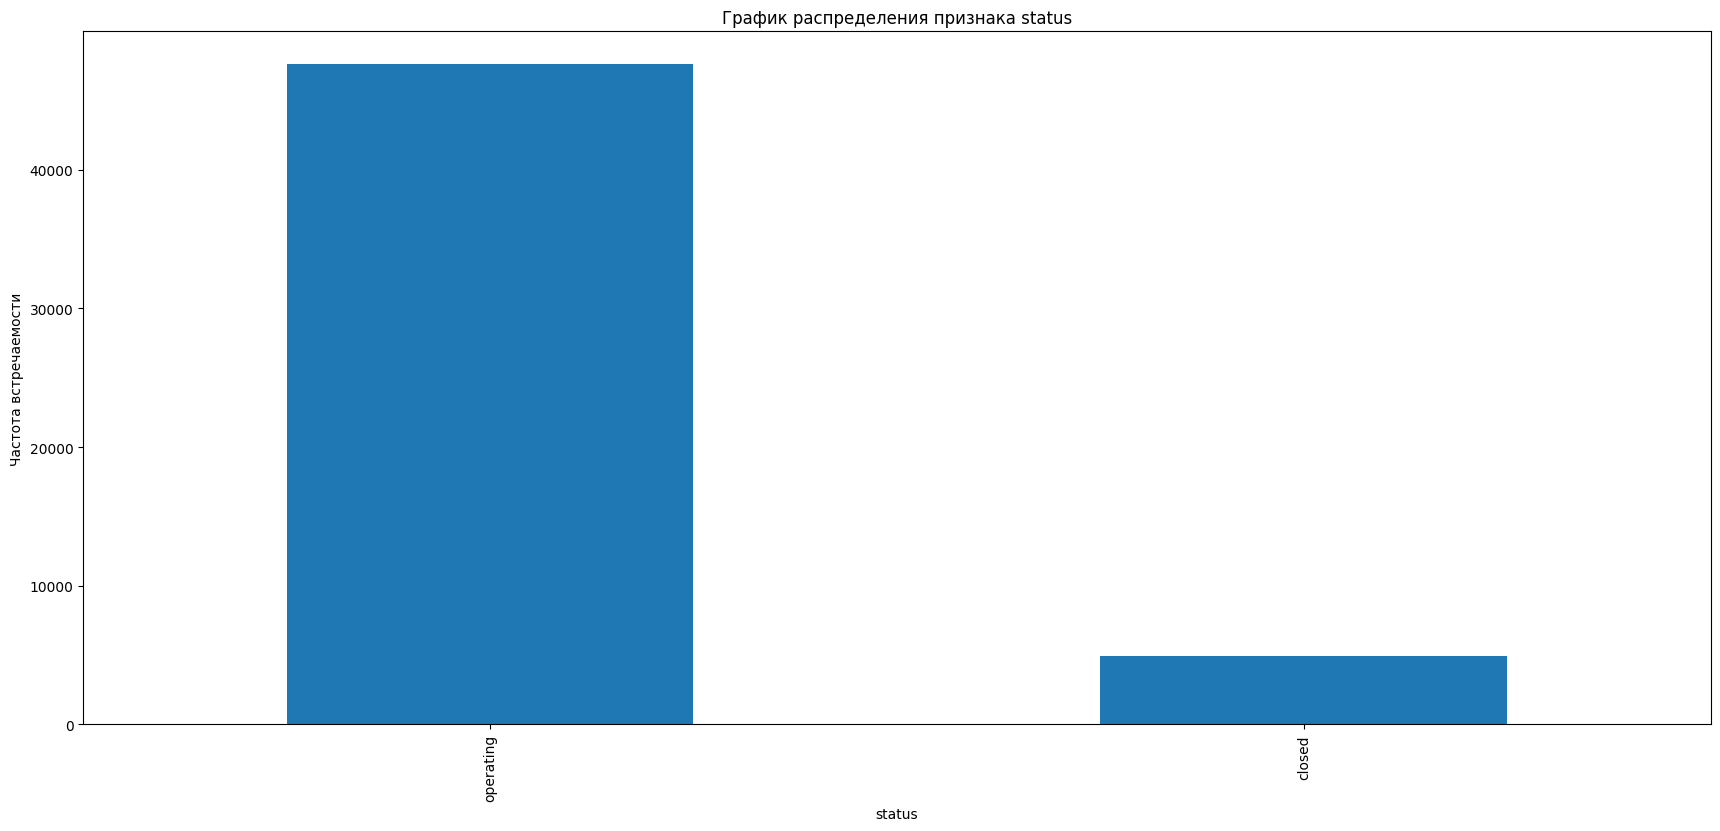




Нормализованное распределение признака country_code:
country_code
USA      0.565580
other    0.104768
GBR      0.055697
CAN      0.029324
IND      0.024297
           ...   
PRY      0.000019
BLM      0.000019
NIC      0.000019
PSE      0.000019
ZMB      0.000019
Name: proportion, Length: 135, dtype: float64


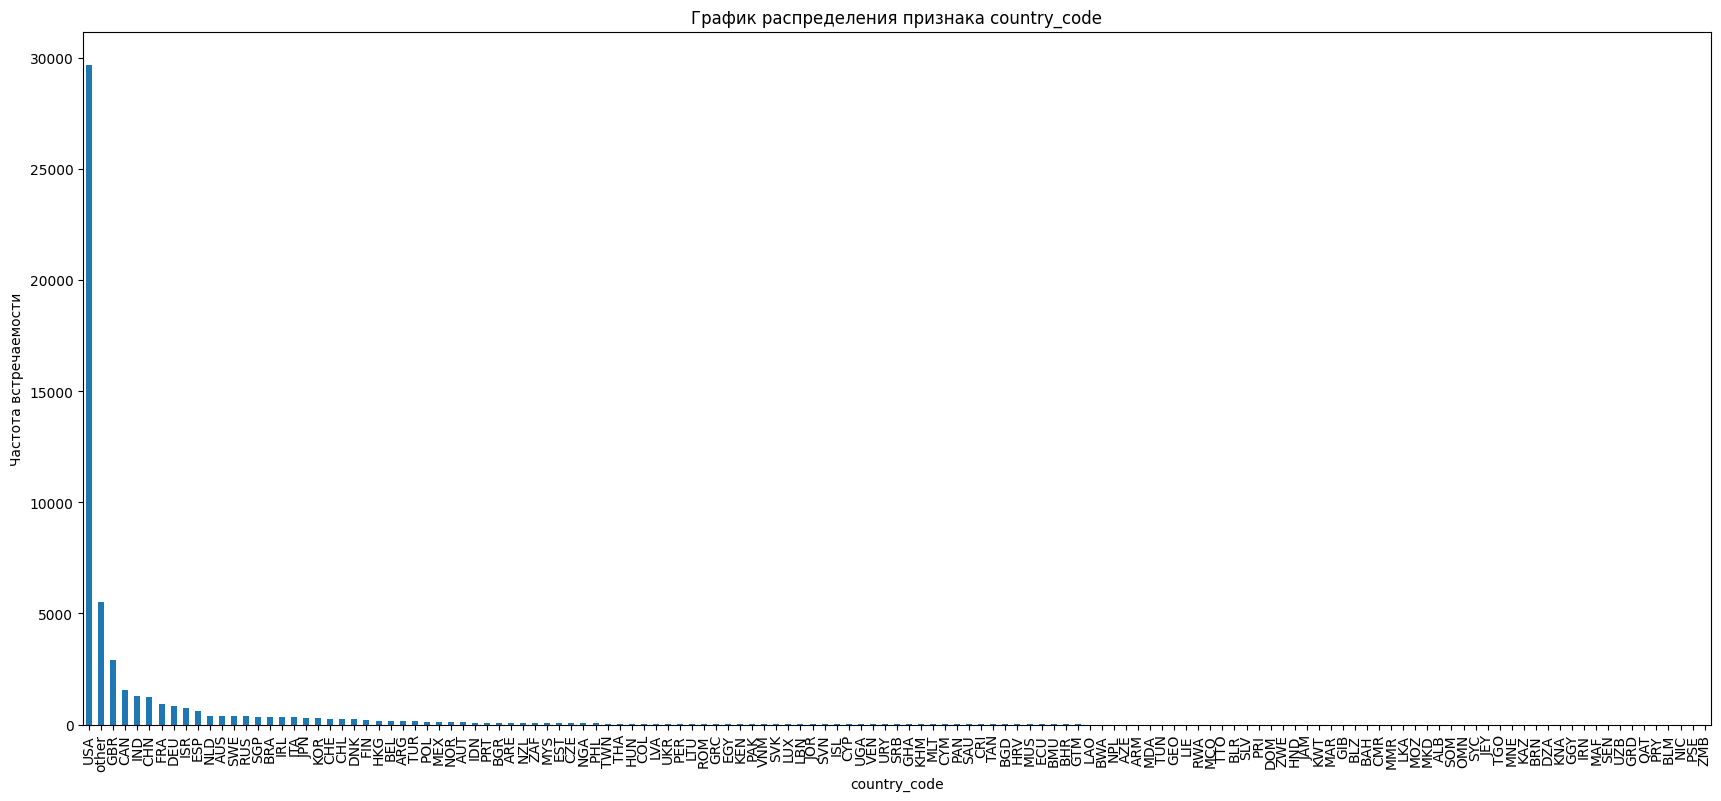

In [478]:
plot_cat_features(train_data[cat_features])

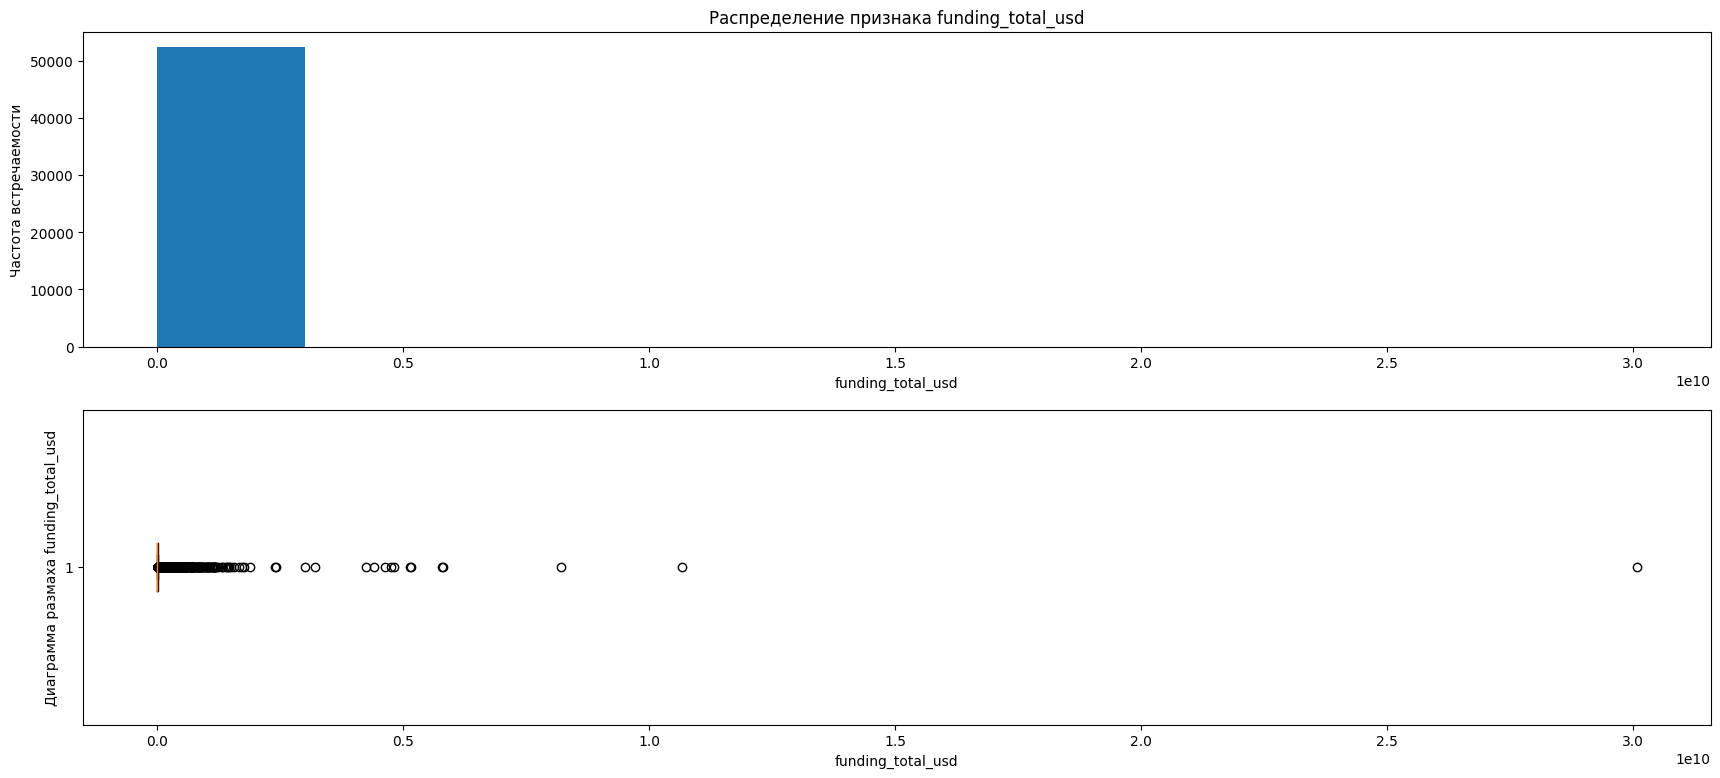

Среднее значение признака funding_total_usd: 16665301.17
Медианное значение признака funding_total_usd: 4246578.50






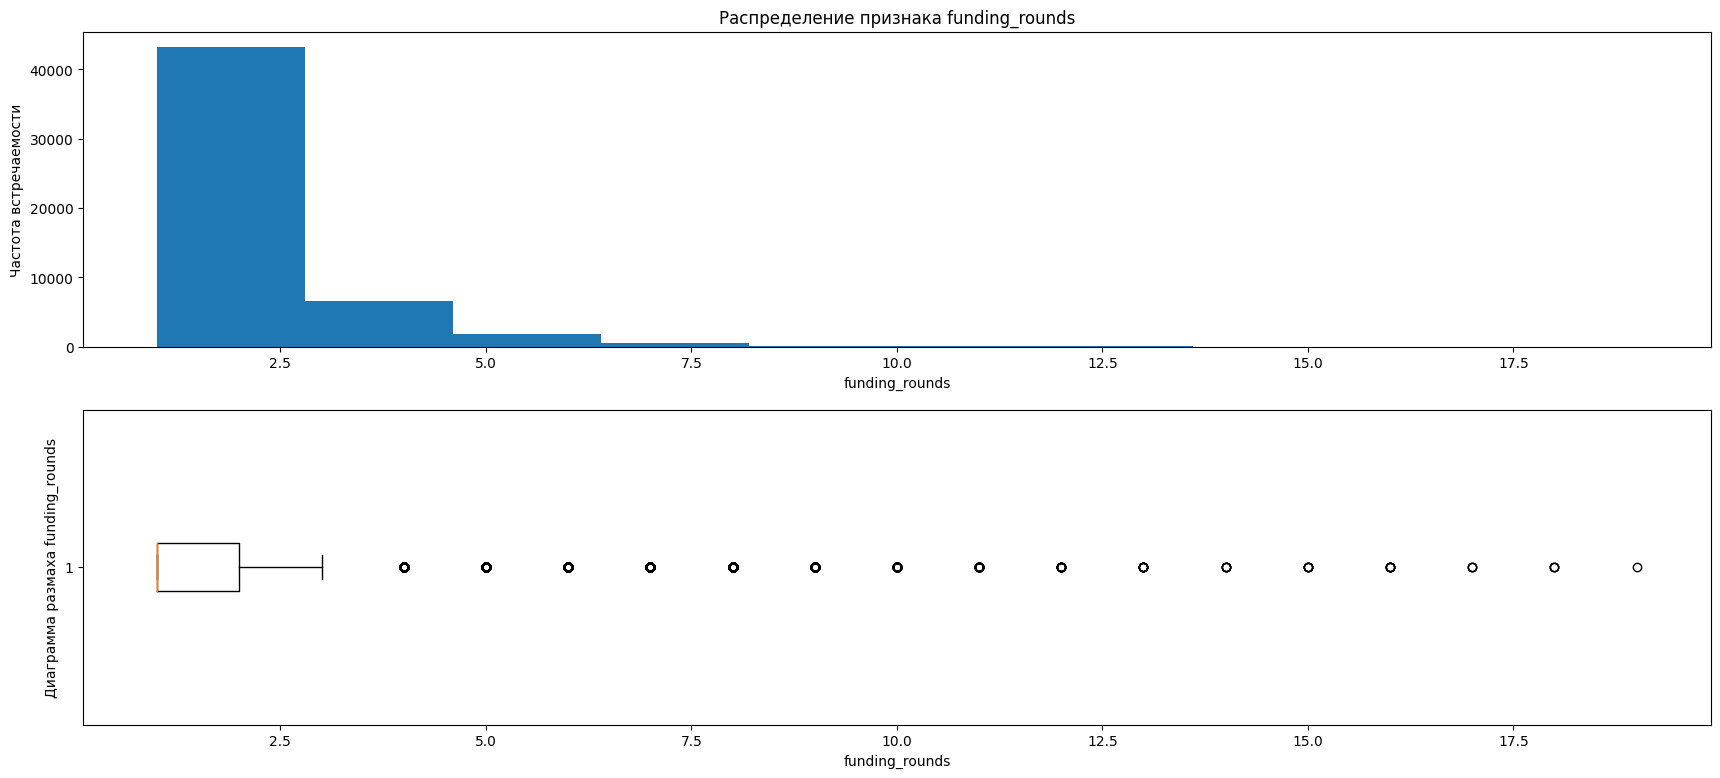

Среднее значение признака funding_rounds: 1.74
Медианное значение признака funding_rounds: 1.00






In [479]:
plot_num_features(train_data[num_features])

Рассмотрим подробнее левую часть графика

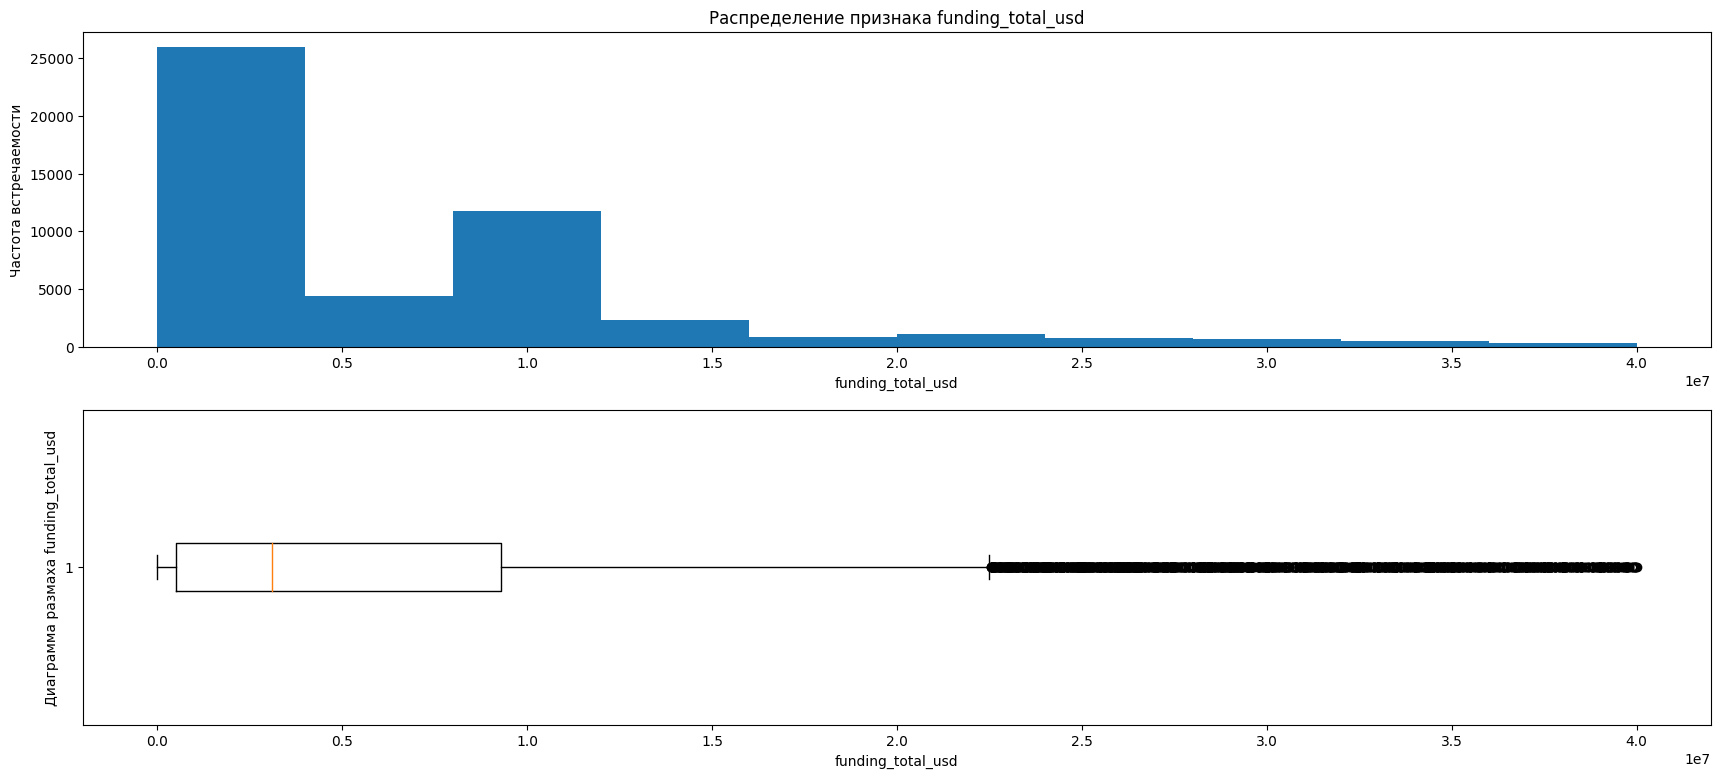

Среднее значение признака funding_total_usd: 6213890.04
Медианное значение признака funding_total_usd: 3108469.00






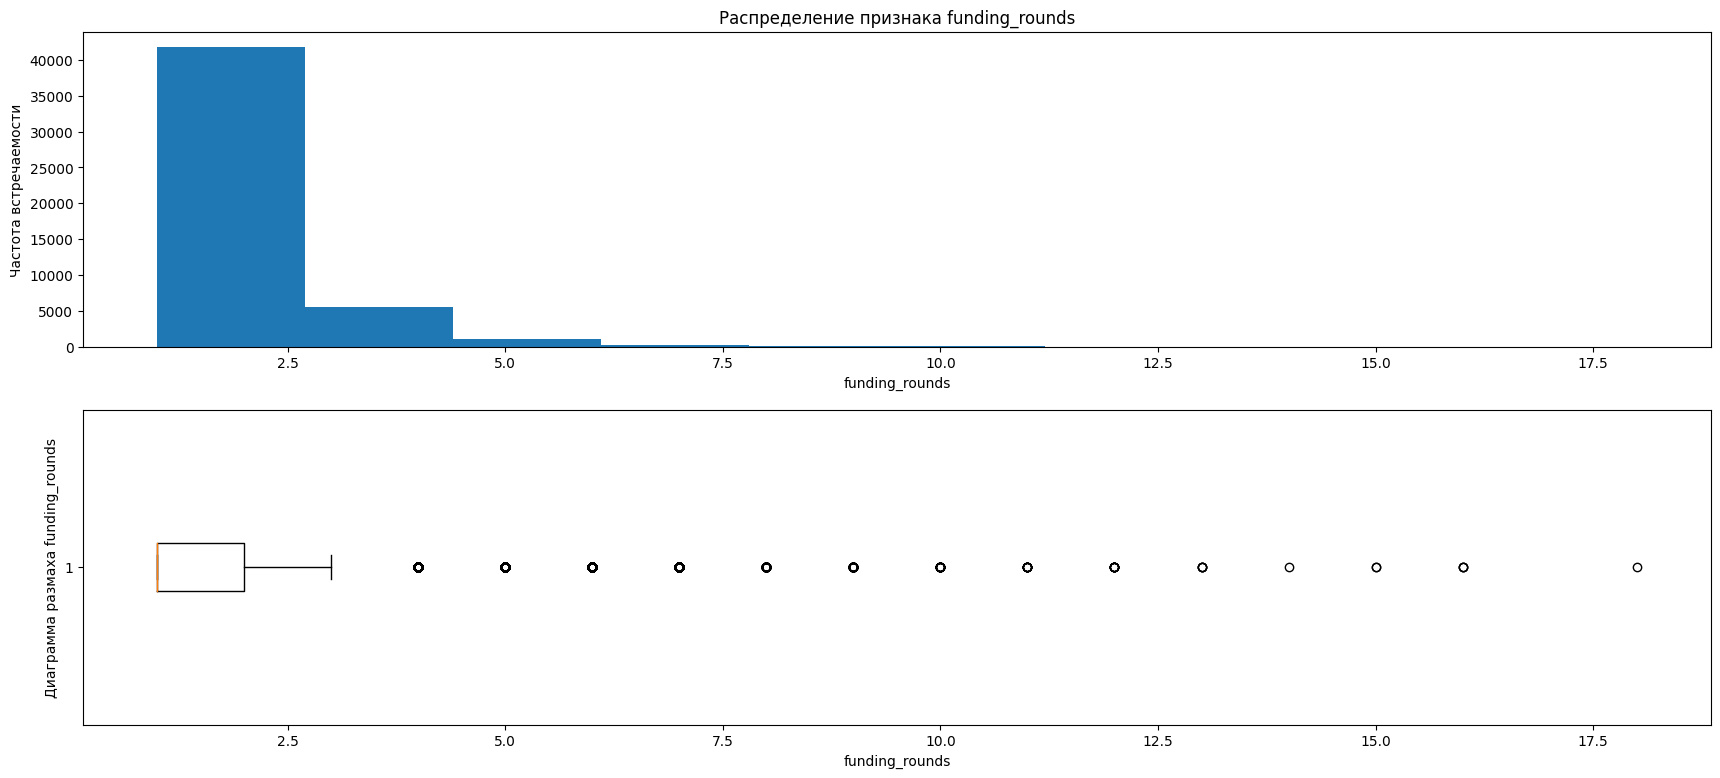

Среднее значение признака funding_rounds: 1.59
Медианное значение признака funding_rounds: 1.00






In [480]:
plot_num_features(train_data.loc[train_data['funding_total_usd'] < 40000000][num_features])

In [481]:
train_data['funding_rounds'].value_counts(normalize = True)

funding_rounds
1     0.637691
2     0.186914
3     0.084736
4     0.041683
5     0.022241
6     0.011730
7     0.006493
8     0.003332
9     0.002076
10    0.001200
11    0.000876
12    0.000419
13    0.000171
16    0.000114
15    0.000095
14    0.000095
17    0.000057
18    0.000057
19    0.000019
Name: proportion, dtype: float64

Распределение признака founded_at:


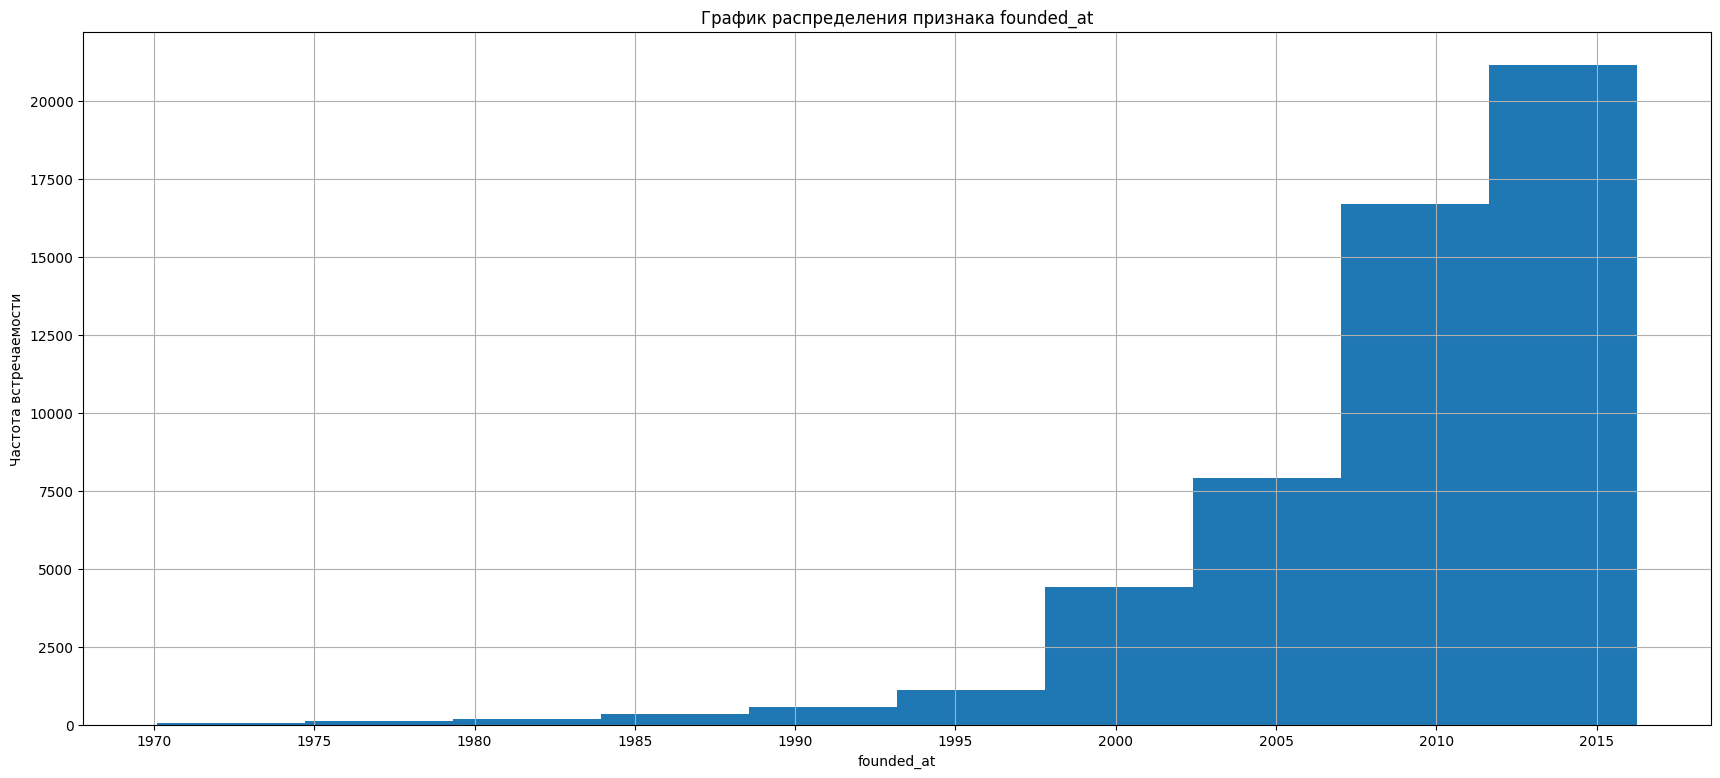

Медианное значение признака founded_at: 2010-10-01 00:00:00




Распределение признака first_funding_at:


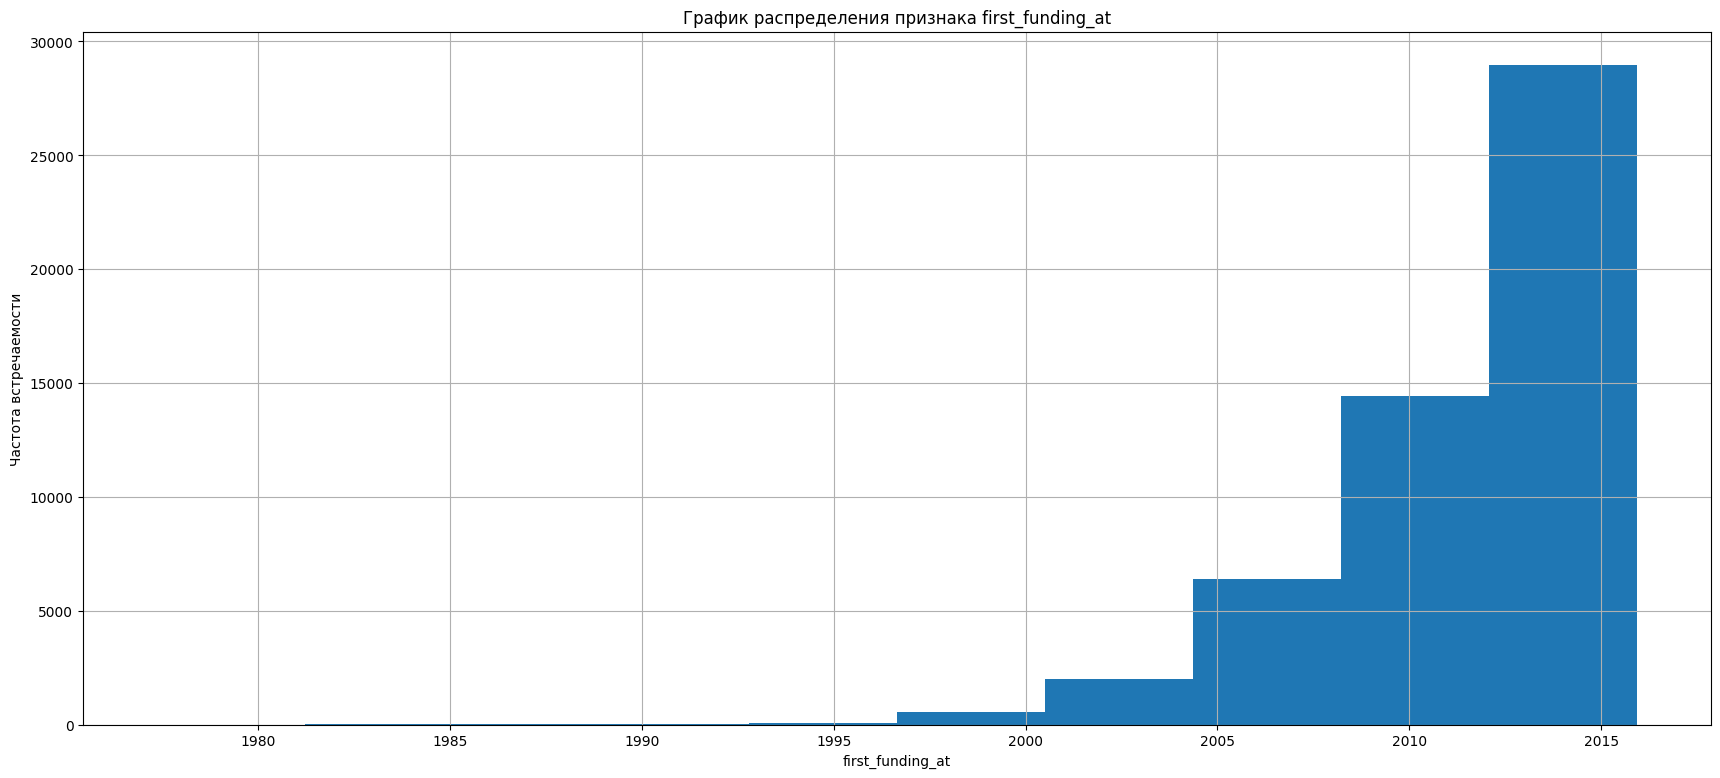

Медианное значение признака first_funding_at: 2012-07-23 00:00:00




Распределение признака last_funding_at:


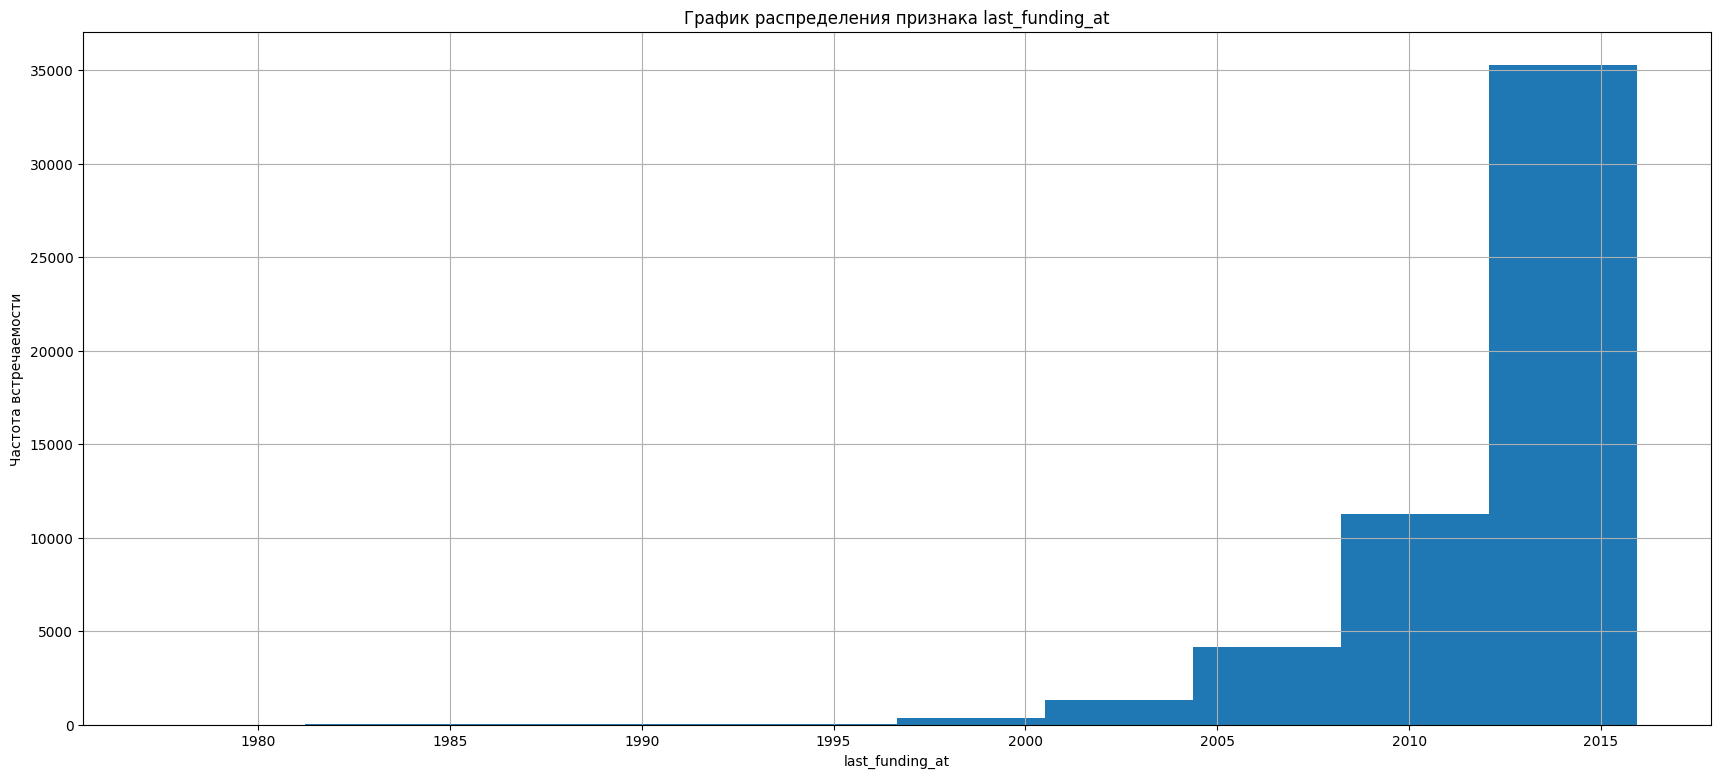

Медианное значение признака last_funding_at: 2013-08-30 00:00:00






In [482]:
plot_datetime_features(train_data[datetime_features])

## Выводы по train_data
- Продолжают работать 90.6% стартапов, остальные закрылись. Наблюдается дисбаланас классов в целевом признаке. 
- Среди всех стран по количеству стартапов явно лидирует США (57%), второе место занимает категория 'other' (10%) - для стартапов, в которых не был указан код страны, затем располагаются Великобритания (5,6%) и Канада (2,9%).
16665301
- Средняя сумма финансирования стартапов составляет 16 665 301 USD, а медианное заметно меньше - 4 246 578 USD. Это обусловлено тем, что есть стартапы с явно большей суммой финансирования. Для большинства же характерный диапазон финансирования составляет от 1 000 000 USD до 9 000 000 USD.
- Для большинства стартапов характерен один (64%) либо два (19%) раундов финансирования.
- Для большинства стартапов и первый, и последний раунды финансирования случились после 2010 года.

Проведем исследовательский анализ test_features

In [483]:
cat_features = ['country_code']
num_features = ['funding_total_usd', 'funding_rounds']
datetime_features = ['first_funding_at', 'last_funding_at']

Нормализованное распределение признака country_code:
country_code
USA      0.565943
other    0.105295
GBR      0.055238
CAN      0.028114
IND      0.023390
           ...   
MKD      0.000076
BHR      0.000076
VEN      0.000076
DMA      0.000076
ZMB      0.000076
Name: proportion, Length: 97, dtype: float64


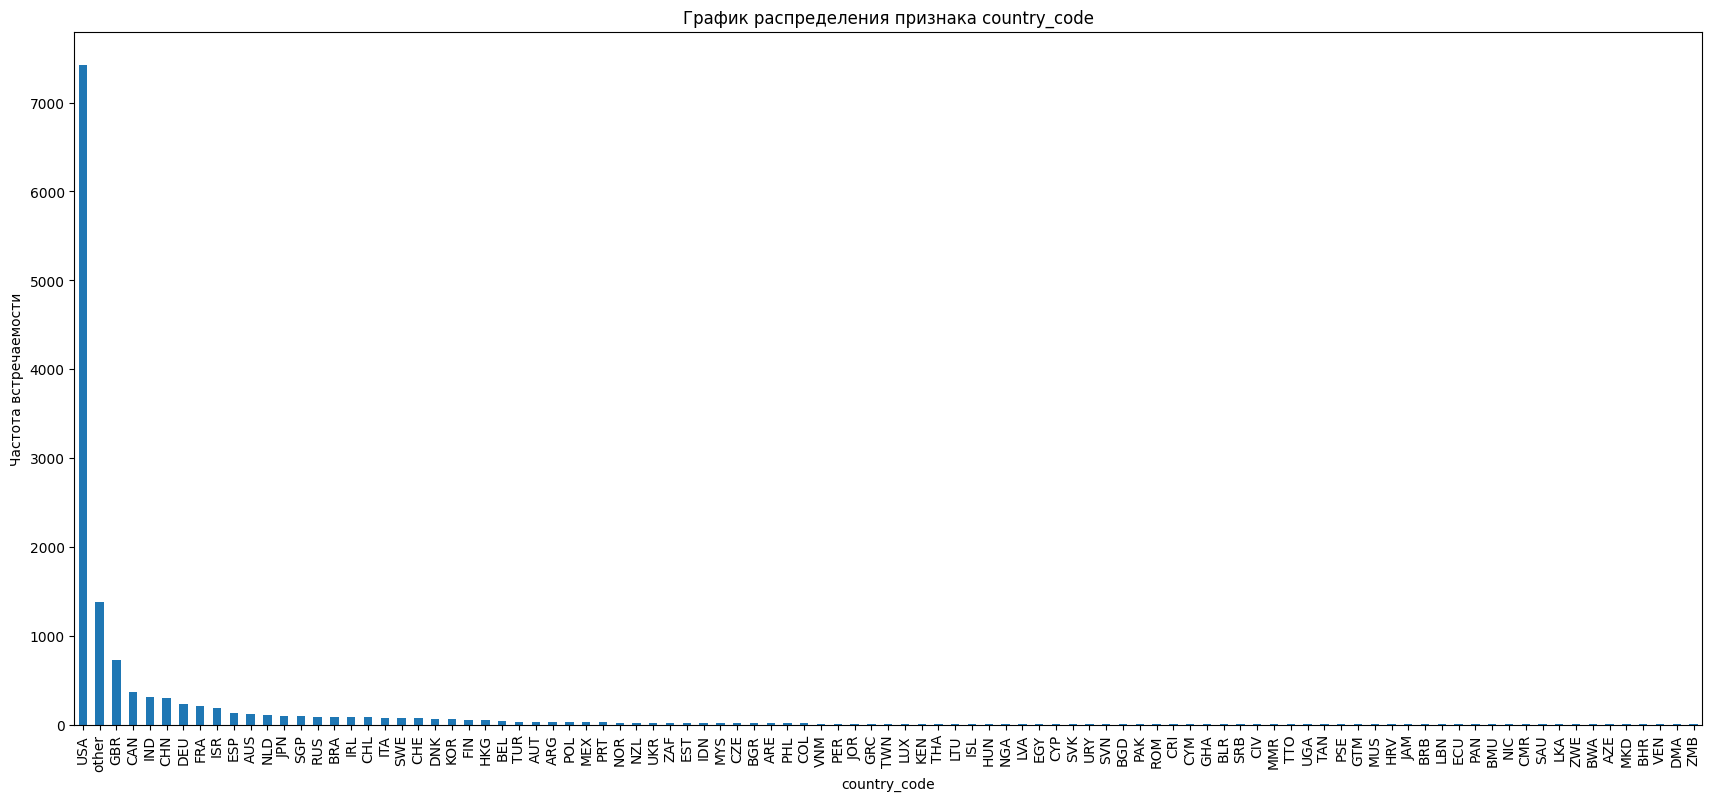

In [484]:
plot_cat_features(test_features[cat_features])

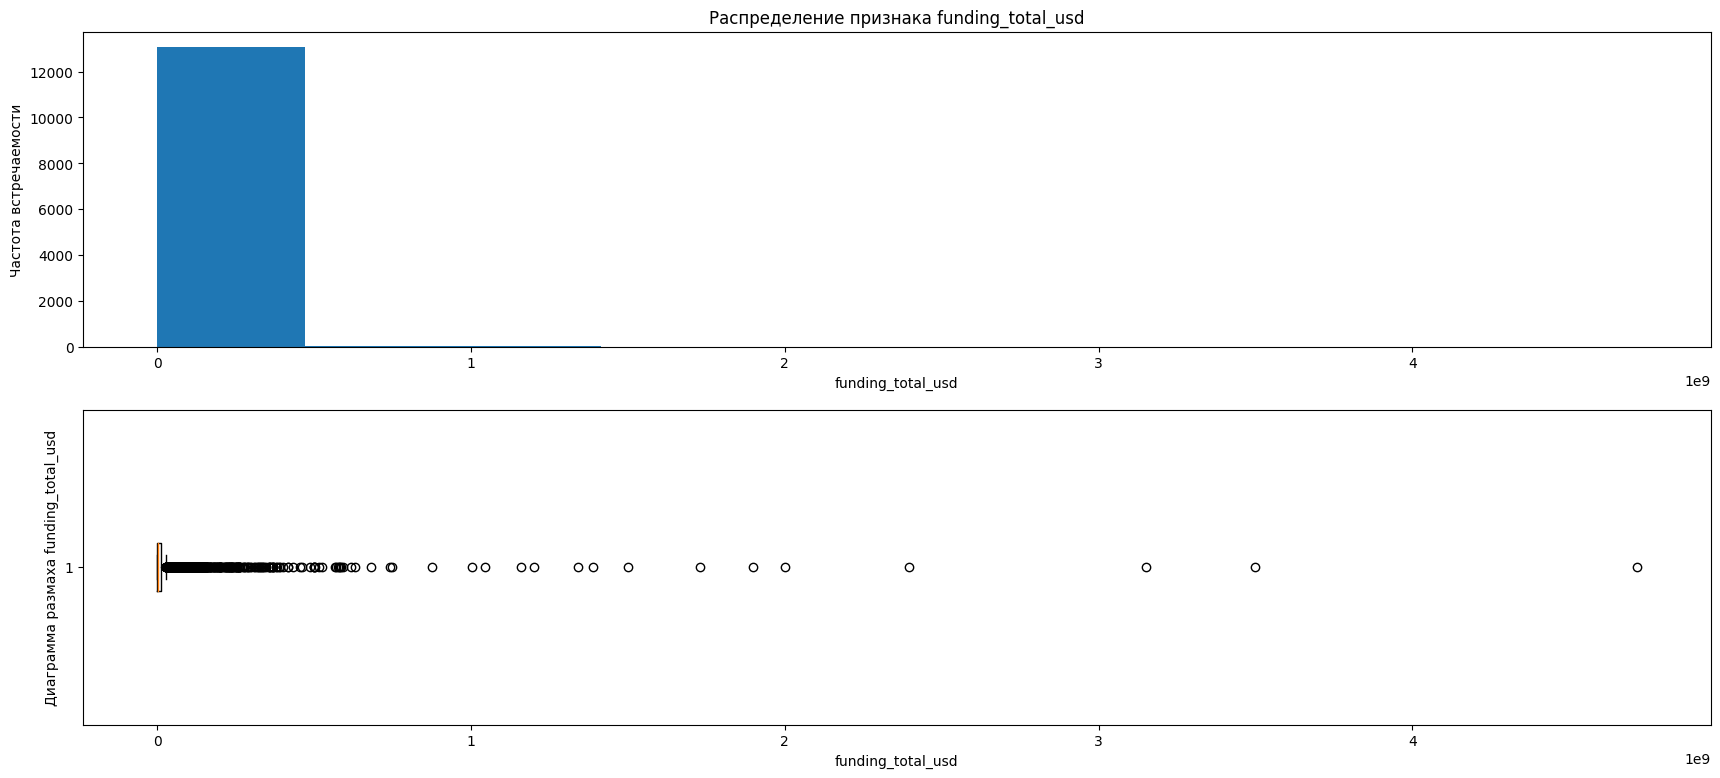

Среднее значение признака funding_total_usd: 16498195.30
Медианное значение признака funding_total_usd: 4297285.00






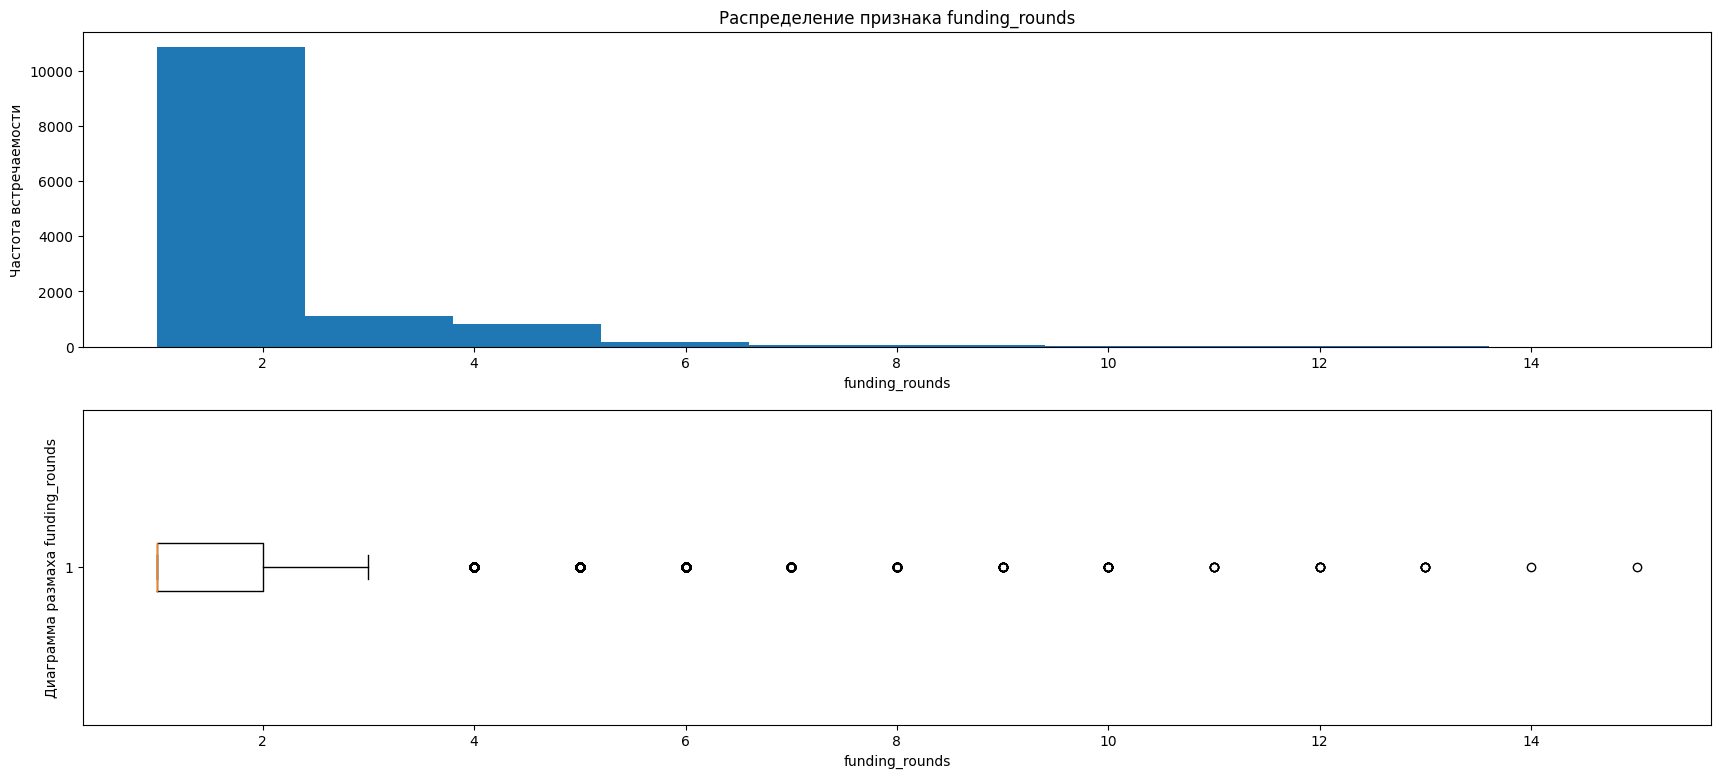

Среднее значение признака funding_rounds: 1.71
Медианное значение признака funding_rounds: 1.00






In [485]:
plot_num_features(test_features[num_features])

Рассмотрим левую часть графика подробнее:

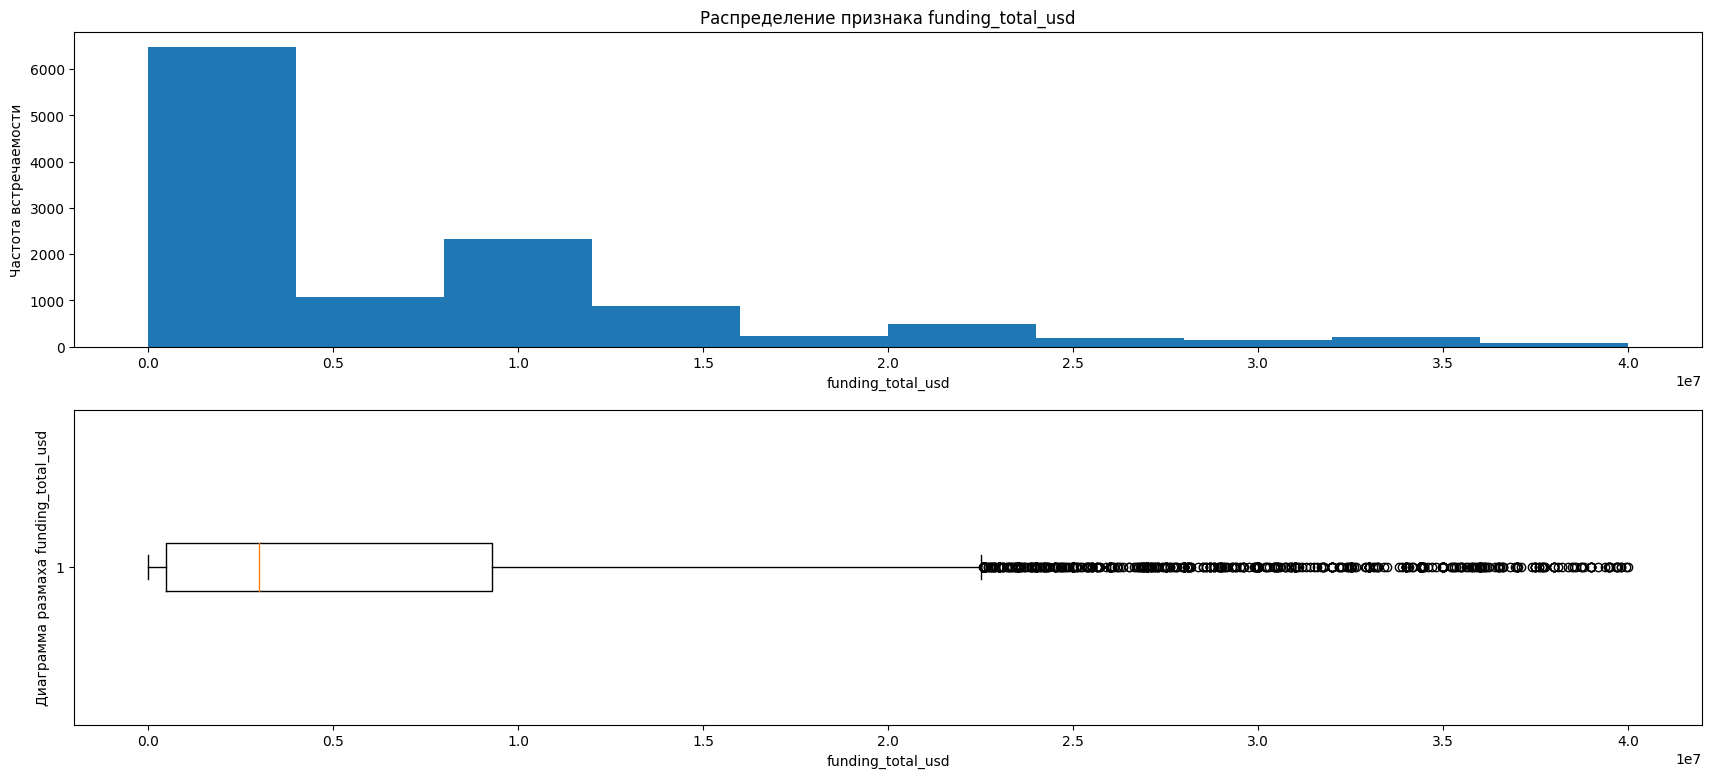

Среднее значение признака funding_total_usd: 6658364.21
Медианное значение признака funding_total_usd: 3000000.00






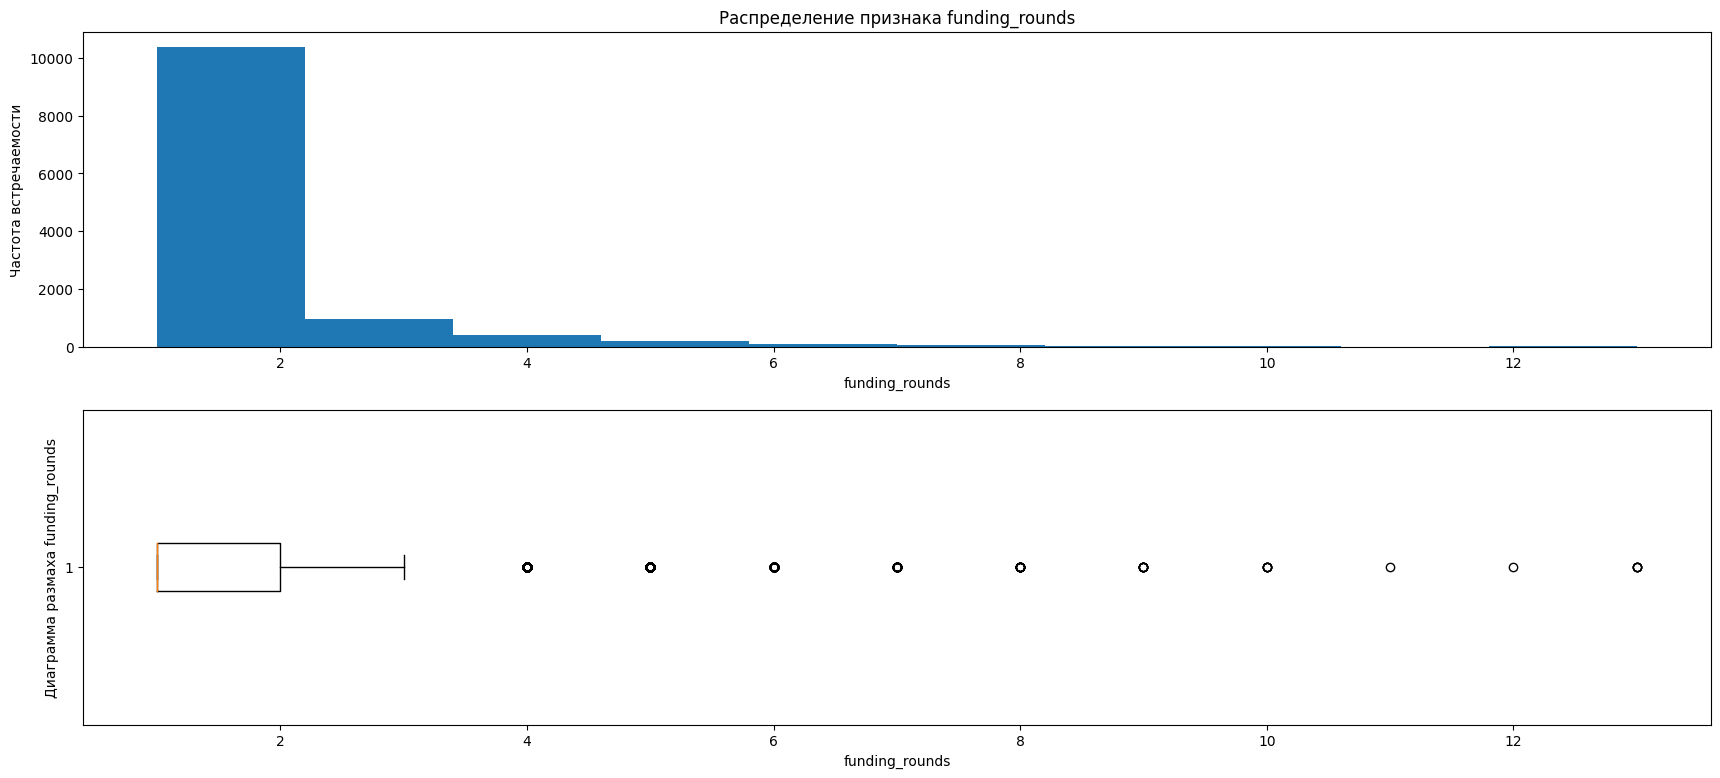

Среднее значение признака funding_rounds: 1.58
Медианное значение признака funding_rounds: 1.00






In [486]:
plot_num_features(test_features.loc[test_features['funding_total_usd'] < 40000000][num_features])

In [487]:
test_features['funding_rounds'].value_counts(normalize = True)

funding_rounds
1     0.643733
2     0.184838
3     0.084648
4     0.040610
5     0.021943
6     0.011581
7     0.005714
8     0.002971
9     0.001295
10    0.001219
12    0.000457
13    0.000457
11    0.000381
15    0.000076
14    0.000076
Name: proportion, dtype: float64

Распределение признака first_funding_at:


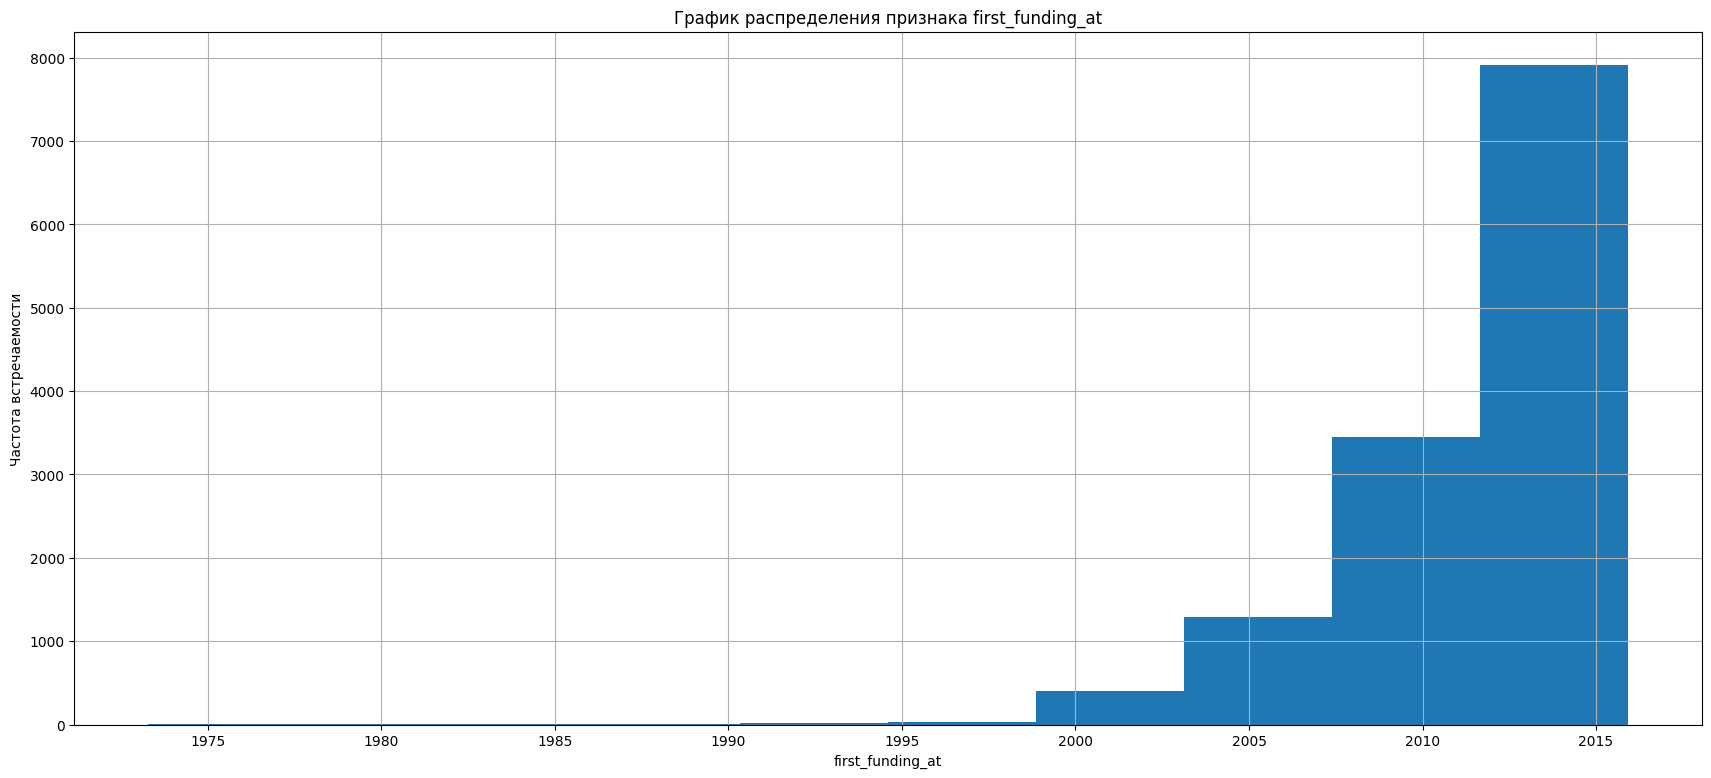

Медианное значение признака first_funding_at: 2012-08-01 00:00:00




Распределение признака last_funding_at:


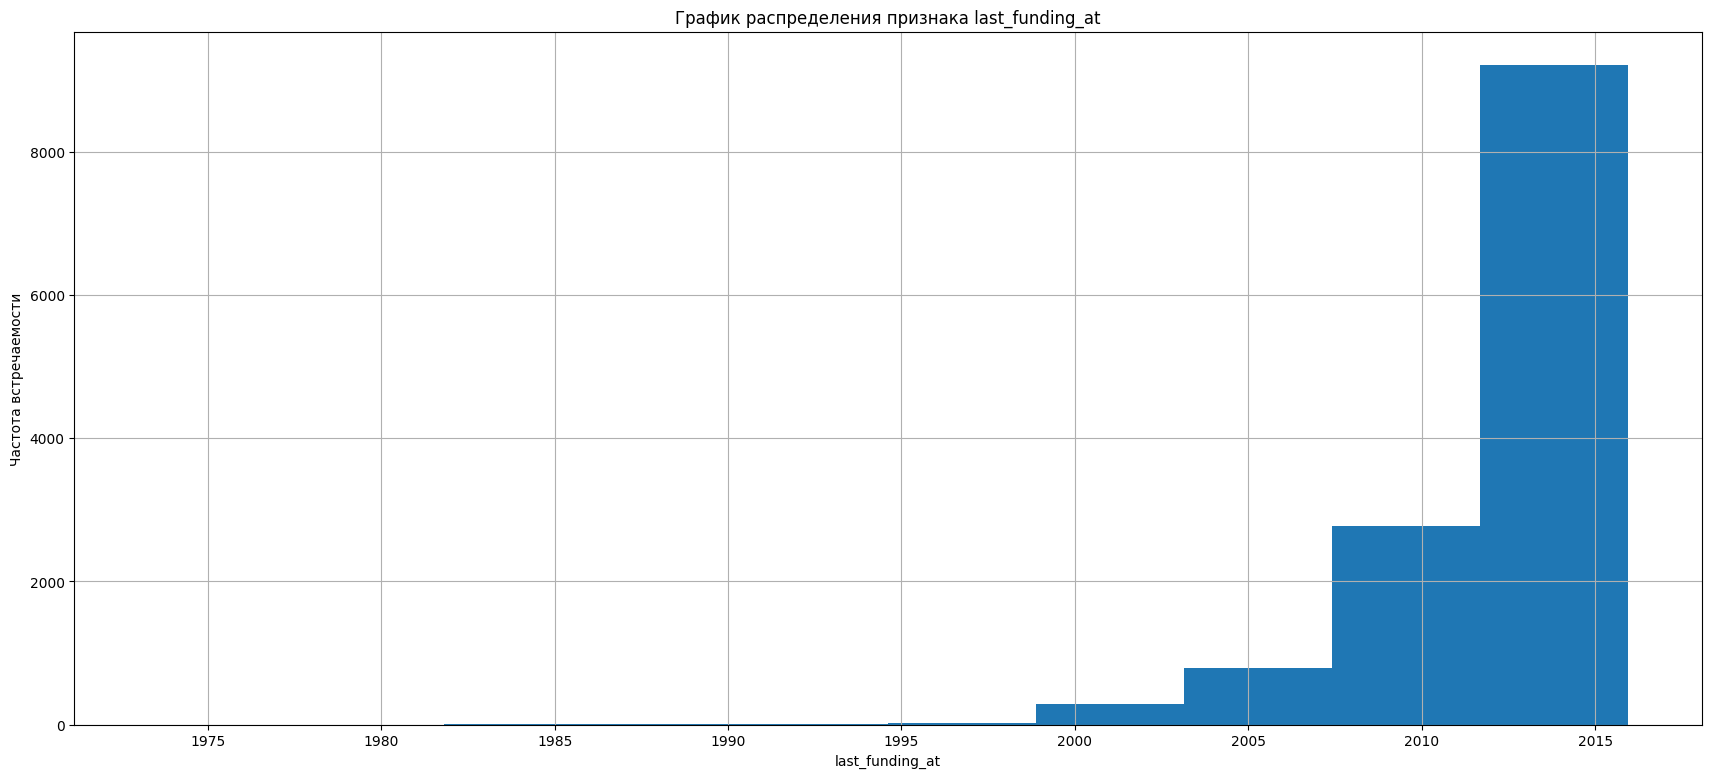

Медианное значение признака last_funding_at: 2013-08-21 00:00:00






In [488]:
plot_datetime_features(test_features[datetime_features])

## Выводы по test_features
Картина схожа с данными в тренировочной выборке:
- Среди всех стран по количеству стартапов явно лидирует США (57%), второе место занимает категория 'other' (10%) - для стартапов, в которых не был указан код страны, затем располагаются Великобритания (5,5%) и Канада (2,8%).
- Средняя сумма финансирования стартапов составляет 16 498 195 USD, а медианное заметно меньше - 4 297 285 USD. Это обусловлено тем, что есть стартапы с явно большей суммой финансирования. Для большинства же характерный диапазон финансирования составляет от 1 000 000 USD до 9 000 000 USD.
- Для большинства стартапов характерен один (64%) либо два (18%) раундов финансирования.
- Для большинства стартапов и первый, и последний раунды финансирования случились после 2010 года.

# 3. Корреляционный анализ данных

Проведем корреляционный анализ признаков в таблице train_data, предварительно преобразовав данные в признаках времени к формату Unix-time

In [489]:
datetime_cols = ['first_funding_at', 'last_funding_at', 'founded_at']
for col in datetime_cols:
    new_col = col + '_unix'
    train_data[new_col] = train_data[col].astype(int)
    train_data[new_col] = train_data[new_col].div(10**9)

In [490]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      52516 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           52516 non-null  object        
 5   state_code             52516 non-null  object        
 6   region                 52516 non-null  object        
 7   city                   52516 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              4917 non-null   object        
 13  f

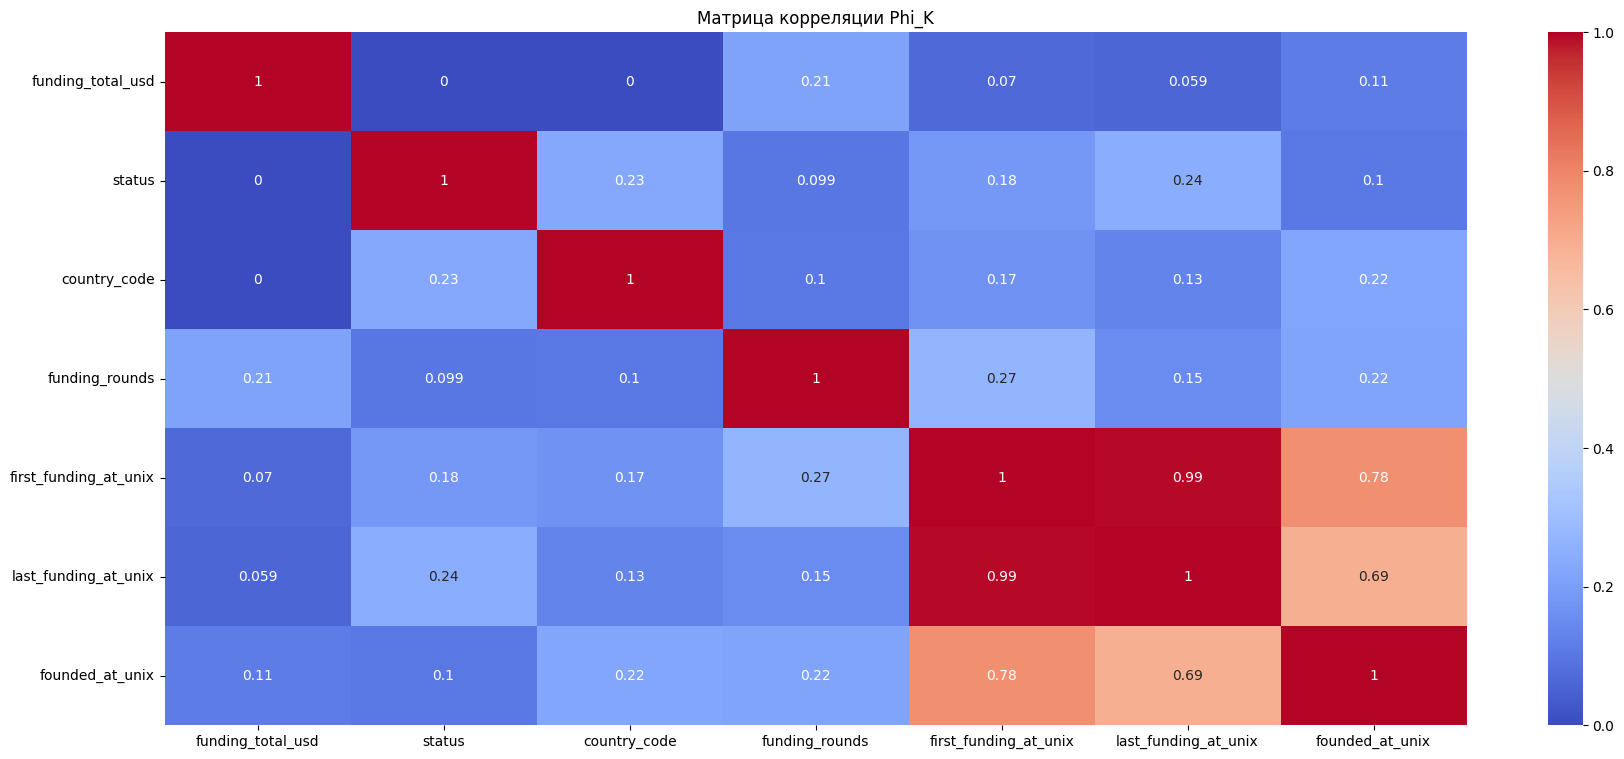

In [491]:
corr_matrix = train_data.drop(['name', 'category_list',\
                               'closed_at', 'first_funding_at', 'last_funding_at',\
                               'founded_at',
                               'state_code', 'region', 'city'], \
                              axis = 1).phik_matrix(interval_cols = \
                                                    ['funding_total_usd','funding_rounds',\
                                                     'first_funding_at_unix', 'last_funding_at_unix',\
                                                     'founded_at_unix'])
plt.figure(figsize=(21, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Phi_K')
plt.show()

Признаки state_code, region и city мультиколлинеарны с признаком country, от них следует избавиться.
Кроме того, наблюдается высокая корреляция (0.99) между признаками first_funding_at_unix и last_funding_at_unix, в таком случае от одного из них придется отказаться.

# 4. Подготовка данных

Разобьем данные на тренировочную и валидационную выборки с учетом стратификации:

In [494]:
X_train, X_test, train_target, test_target = train_test_split(
    train_data.drop(['name', 'status', 'state_code', 'region', 'city', 'founded_at', 'closed_at',\
                     'first_funding_at', 'last_funding_at', 'founded_at_unix'], axis=1),
    train_data['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train_data['status'])

In [495]:
X_train.head()

,category_list,funding_total_usd,country_code,funding_rounds,first_funding_at_unix,last_funding_at_unix
33502,other,9.302247e+06,AUS,1,1.325376e+09,1.325376e+09
27333,Machine Learning,1.000000e+07,USA,1,1.415750e+09,1.415750e+09
7596,Curated Web|Video,4.584180e+06,USA,8,1.170288e+09,1.371773e+09
47478,Real Estate|Rental Housing,2.700000e+05,USA,1,1.415750e+09,1.415750e+09
22824,Consumers|Games,9.302247e+06,SGP,1,1.372637e+09,1.372637e+09


Произведем кодирование целевого признака с помощью LabelEncoder:

In [496]:
label_encoder = LabelEncoder()
label_encoder.fit(train_target)
train_target_encoded = label_encoder.transform(train_target)
test_target_encoded = label_encoder.transform(test_target)
pd.DataFrame(train_target_encoded, train_target, columns=['LabelEncoder']).head(20)

,LabelEncoder
status,
operating,1
operating,1
operating,1
operating,1
operating,1
operating,1
operating,1
operating,1
operating,1


Теперь факт успешности стартапа отраджен значением 1, а факт закрытия - 0. 

Выделим признаки для кодирования:

In [497]:
num_columns = ['funding_total_usd', 'funding_rounds', 'first_funding_at_unix', 'last_funding_at_unix']

Создадим общий пайплайн для подготовки данных:

In [500]:
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создадим итоговый пайплайн, в котором будет подготовка данных и модель. Используем модель CatBoost, так как она хорошо работает на несбалансированных данных, а также умеет работать с категориальными признаками:

In [501]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(random_seed=RANDOM_STATE))
])

## Выводы по четвертому этапу
- выделены признаки и признаки для кодирования;
- произведено кодирование целевого признака с помощью LabelEncoder;
- созданы пайплайны для обучения моделей.

# 5. Обучение моделей

Определим параметры для перебора в GridSearchCV:

In [503]:
param_grid = [
    {
        'models': [CatBoostClassifier(iterations = 1000, random_seed=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }

]

Зададим условия для поиска гиперпараметров с помощью GridSearchCV:


In [504]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring = 'f1',
    n_jobs=-1
)

Выделим категорильные признаки для передачи их модели CatBoostClassifier в пайплайне:

In [506]:
scaled_X = data_preprocessor.fit_transform(X_train)
new_df = pd.DataFrame(scaled_X)
new_df = new_df.infer_objects()
cat_features_new = [new_df.columns.get_loc(col) for col in new_df.select_dtypes(include=['object', 'bool']).columns]
cat_features_new

[4, 5]

Выполним поиск оптимальных параметров:

In [507]:
grid_search.fit(X_train, train_target_encoded, models__cat_features = cat_features_new, models__verbose = False);

In [508]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'first_funding_at_unix',
                                                   'last_funding_at_unix'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x78fad639ae30>)])


In [509]:
grid_search.best_score_

0.9514767613245073

Выполним предсказания на валидационной выборке:

In [513]:
pred = grid_search.predict(X_test)
f1_score(test_target_encoded, pred)

0.9512077294685991

На обучающей и валидационной выборках метрика модели более 95%.

Выполним предсказания на тестовой выборке. Для этого приведем ее к соответсвующему виду:

In [516]:
datetime_cols = ['first_funding_at', 'last_funding_at']
for col in datetime_cols:
    new_col = col + '_unix'
    test_features[new_col] = test_features[col].astype(int)
    test_features[new_col] = test_features[new_col].div(10**9)

In [517]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   13125 non-null  object        
 1   category_list          13125 non-null  object        
 2   funding_total_usd      13125 non-null  float64       
 3   country_code           13125 non-null  object        
 4   state_code             13125 non-null  object        
 5   region                 13125 non-null  object        
 6   city                   13125 non-null  object        
 7   funding_rounds         13125 non-null  int64         
 8   first_funding_at       13125 non-null  datetime64[ns]
 9   last_funding_at        13125 non-null  datetime64[ns]
 10  lifetime               13125 non-null  int64         
 11  first_funding_at_unix  13125 non-null  float64       
 12  last_funding_at_unix   13125 non-null  float64       
dtypes

In [520]:
test_features_to_process = test_features.drop(['name', 'state_code', 'region', 'city', 'lifetime', 'first_funding_at', 'last_funding_at'], axis = 1)

In [521]:
test_features_to_process

,category_list,funding_total_usd,country_code,funding_rounds,first_funding_at_unix,last_funding_at_unix
0,Clean Technology,2.819200e+06,NIC,1,1.246406e+09,1.246406e+09
1,Hospitality,3.439820e+07,USA,1,1.280275e+09,1.280275e+09
2,Finance,4.282570e+05,LUX,2,1.400112e+09,1.410998e+09
3,Software|Video|Video Streaming,3.470000e+07,USA,4,1.104538e+09,1.271722e+09
4,Software,4.530000e+06,CAN,1,1.178582e+09,1.178582e+09
...,...,...,...,...,...,...
13120,Recruiting,2.800000e+04,USA,1,1.341101e+09,1.341101e+09
13121,Software,9.302247e+06,USA,1,1.380586e+09,1.380586e+09
13122,Design|E-Commerce|Marketplaces|Printing,5.600000e+06,USA,3,1.220227e+09,1.309219e+09
13123,Advertising Exchanges|Mobile|Mobile Advertising,1.500000e+05,USA,2,1.411776e+09,1.415059e+09


In [522]:
pred = grid_search.predict(test_features_to_process)

Добавим предсказания в датафрейм:

In [524]:
test_features['preds'] = pred

In [ ]:
test_features['status'] = test_features['preds'].apply(lambda x: 'operating' if x == 1 else 'closed')

Запишем предсказания на тестовой выборке в файл:

In [535]:
test_features[['name', 'status']].to_csv('tuilen.csv', index=False)

## Выводы по пятому этапу
Осуществлен подбор парамеров модели классификации. Оптимальной оказалась модель CatBoostClassifier с предварительной обработкой количествнных признаков с помощью MinMaxScaler: ее метрика f1 на валидационной выборке составляет 95.1%.

# 6. Оценка важности признаков

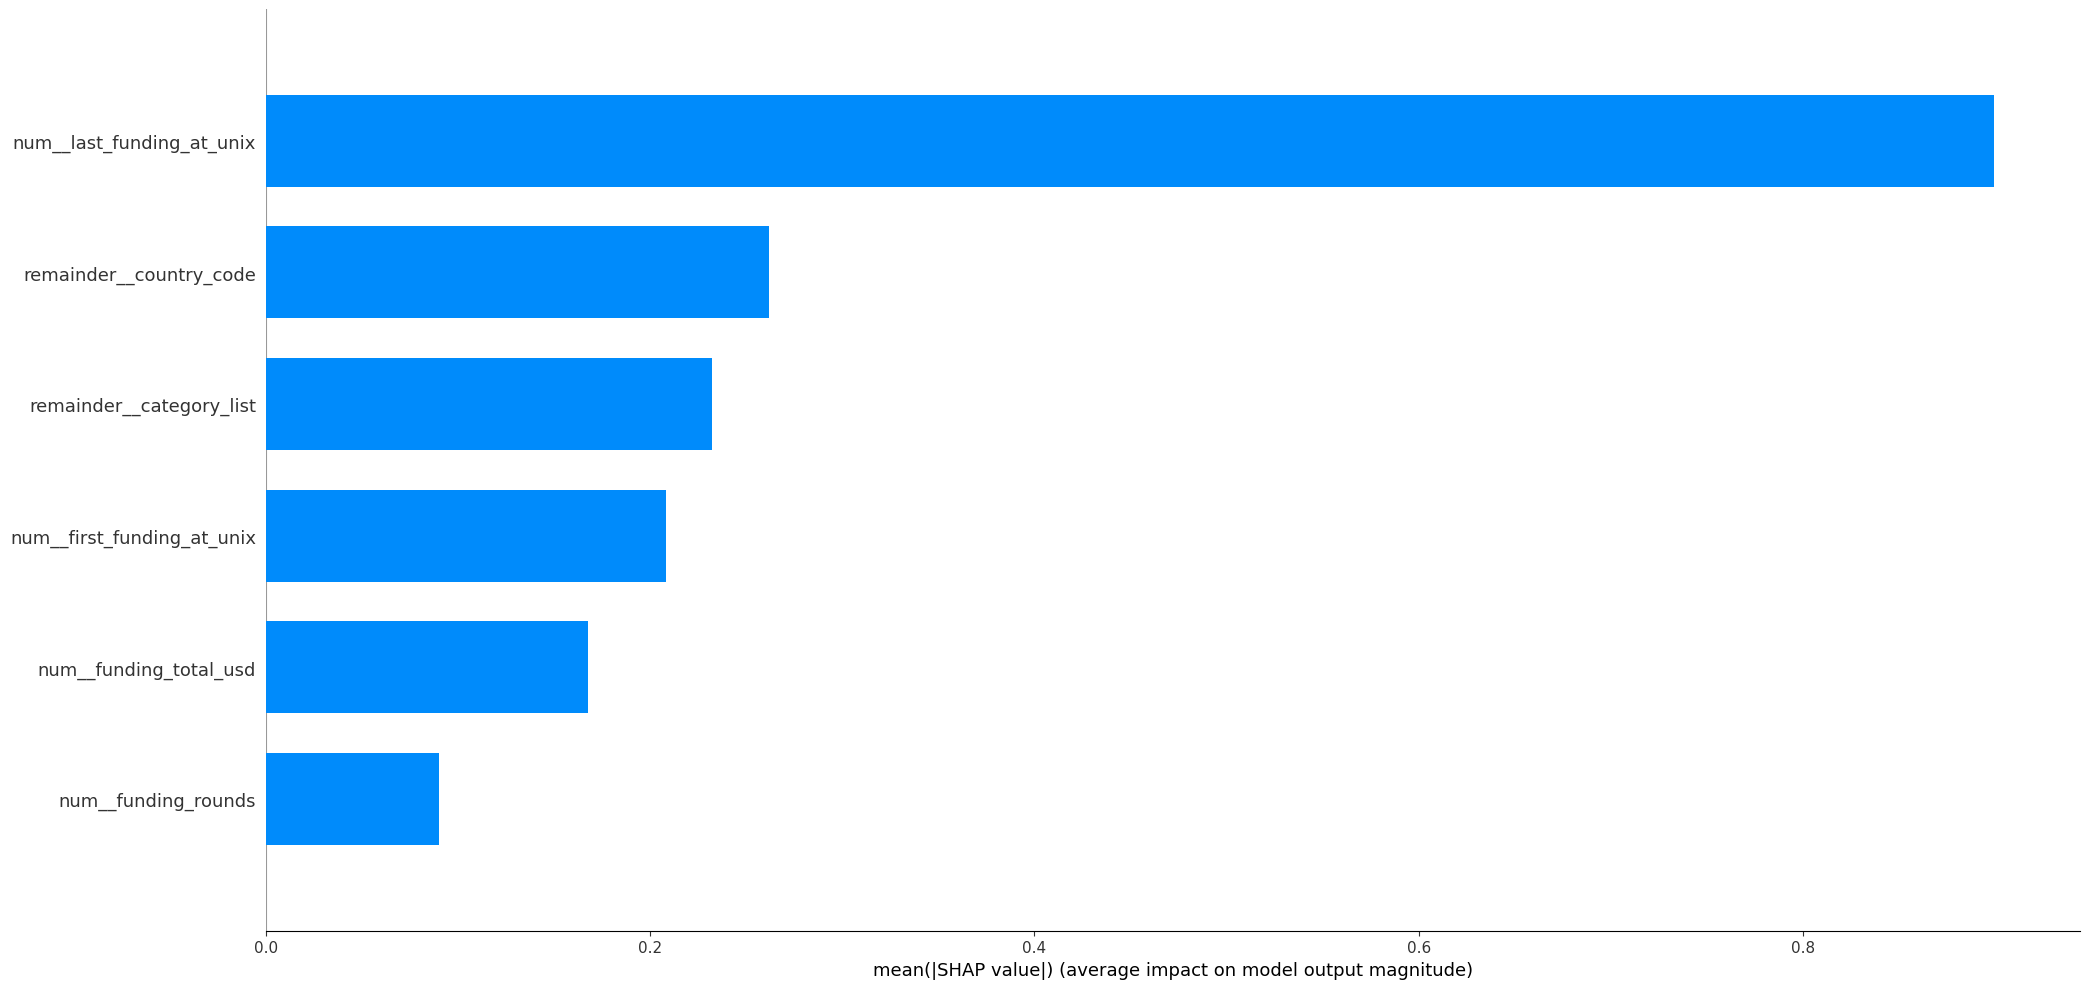

In [541]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
explainer = shap.TreeExplainer(grid_search.best_estimator_.named_steps['models'])
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
shap_values = explainer(X_test_2) 
shap.summary_plot(shap_values, plot_type = 'bar', plot_size = (21, 10))

Наибольшее влияние на целевой признак оказывает дата последнего раунда финансирования, нименьшее - общая сумма финансирования и количество раундов финансирования.

# 7. Выводы
Проведено исследование данных о стартапах в период с 1970 по 2018 годы.
Построена модель для предсказания закрытия стартапа на основании CatBoostClassifier, ее метрика на валидационной выборке составляет 95.1%.
Также проведен анализ важности признаков для указанной модели. Наибольшее влияние на целевой признак оказывает дата последнего раунда финансирования, нименьшее - общая сумма финансирования и количество раундов финансирования.